# XGBOOST_Titanic

In [1]:
#survival------表示乘客是否存活；0=No，1=Yes
#pclass------表示票的等级；1=1st，2=2nd，3=3rd
#sex------表示乘客性别；
#Age------表示乘客年龄
#sibsp------表示在船上的兄弟姐妹加上配偶的数量
#parch------表示在船上的父母加上子女的数量
#ticket------表示票的编号
#fare------表示票价
#cabin------表示船舱编号
#embarked------表示乘客登录的港口；C = Cherbourg, Q = Queenstown, S = Southampton

In [2]:
#Matplotlib试着让简单的事情更加简单，困难的事情变得可能，而Seaborn就是让困难的东西更加简单。
#seaborn是针对统计绘图的，一般来说，seaborn能满足数据分析90%的绘图需求，够用了，
#如果需要复杂的自定义图形，还是要Matplotlib。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings('ignore')

D:\mathwork\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train=pd.read_csv("E:/datasets/kaggle/Titanic-dataset/train.csv")
test=pd.read_csv("E:/datasets/kaggle/Titanic-dataset/test.csv")

In [4]:
train.info()
#训练集有891个样本，12个特征，所有数据占内存83.6kb，age和cabin缺失严重，embarked缺失不严重
#三种数据类型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


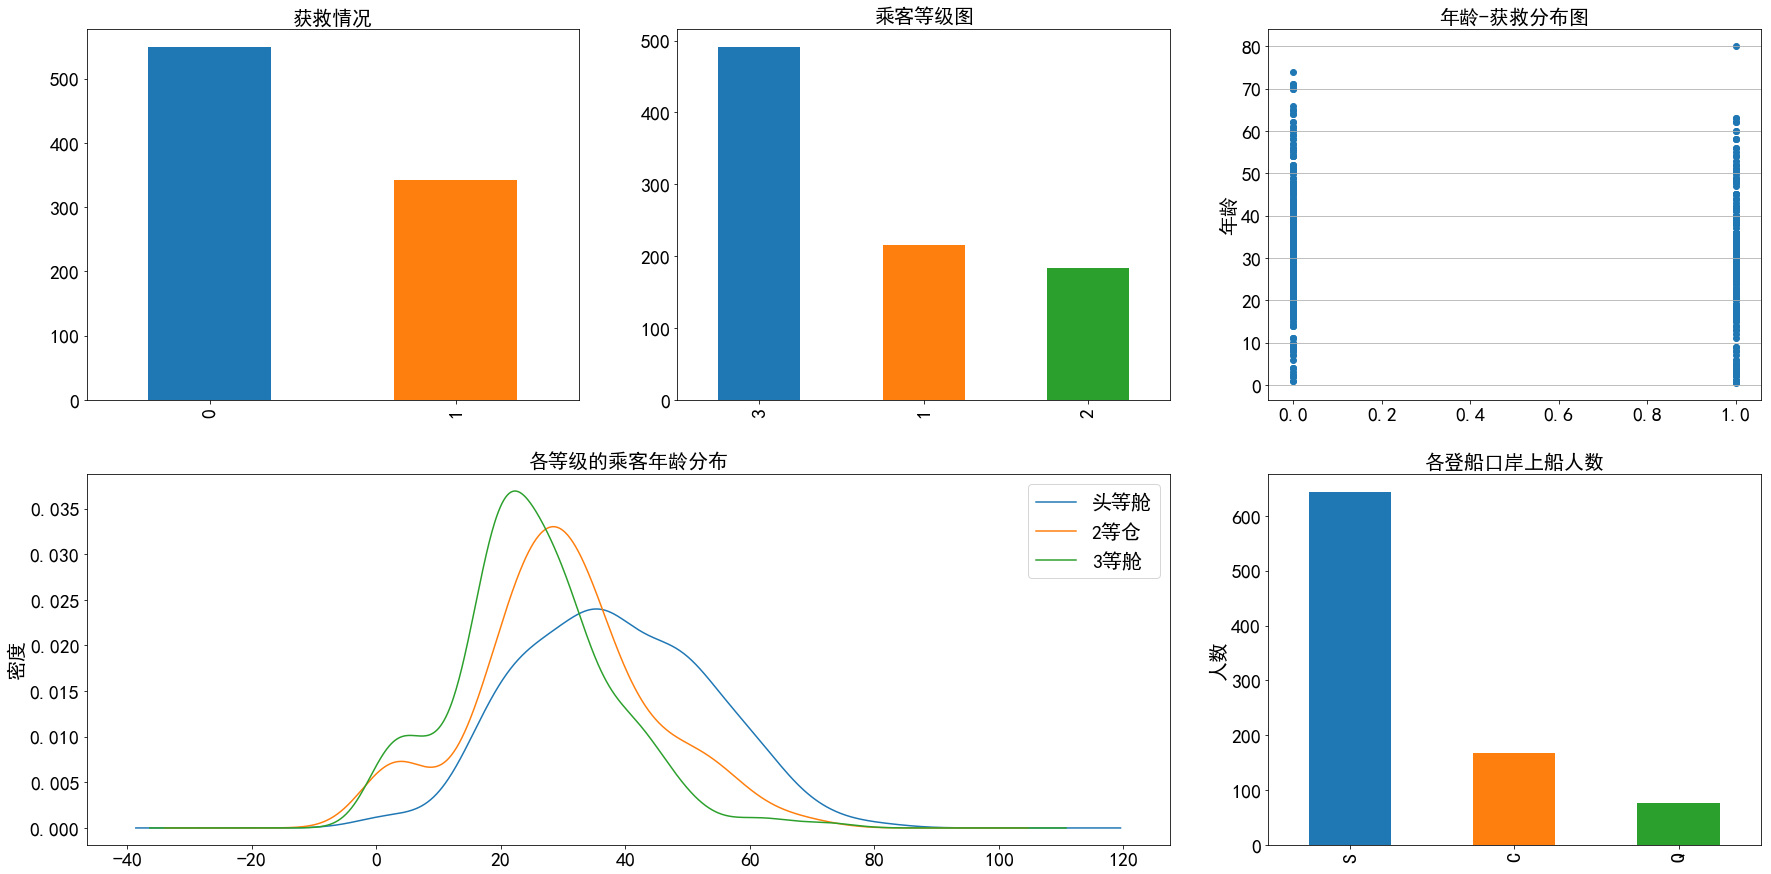

In [20]:
fig=plt.figure()
fig.set(alpha=0.2)
fontsize=20

plt.subplot2grid((2,3),(0,0))
train['Survived'].value_counts().plot(kind='bar')
plt.title('获救情况',fontsize=fontsize)
plt.xticks(fontsize=fontsize) #x刻度
plt.yticks(fontsize=fontsize) #y刻度

plt.subplot2grid((2,3),(0,1))
train['Pclass'].value_counts().plot(kind='bar')
plt.title('乘客等级图',fontsize=fontsize)
plt.xticks(fontsize=fontsize) #x刻度
plt.yticks(fontsize=fontsize) #y刻度

plt.subplot2grid((2,3),(0,2))
plt.scatter(train['Survived'],train['Age'])
plt.ylabel('年龄',fontsize=fontsize)
plt.grid(b=True,which='major',axis='y')
plt.title('年龄-获救分布图',fontsize=fontsize)
plt.xticks(fontsize=fontsize) #x刻度
plt.yticks(fontsize=fontsize) #y刻度

plt.subplot2grid((2,3),(1,0),colspan=2)
train[train['Pclass']==1]['Age'].plot(kind='kde')
train[train['Pclass']==2]['Age'].plot(kind='kde')
train[train['Pclass']==3]['Age'].plot(kind='kde')
plt.ylabel('密度',fontsize=20)
plt.title('各等级的乘客年龄分布',fontsize=20)
plt.legend(('头等舱',u'2等仓',u'3等舱'),loc='best',fontsize=20)
plt.xticks(fontsize=fontsize) #x刻度
plt.yticks(fontsize=fontsize) #y刻度

plt.subplot2grid((2,3),(1,2))
train['Embarked'].value_counts().plot(kind='bar')
plt.title('各登船口岸上船人数',fontsize=20)
plt.ylabel('人数',fontsize=fontsize)
plt.xticks(fontsize=fontsize) #x刻度
plt.yticks(fontsize=fontsize) #y刻度

plt.rcParams['figure.figsize'] = (30.0, 15.0)  #设置图片大小
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.show()

<Figure size 2160x1080 with 0 Axes>

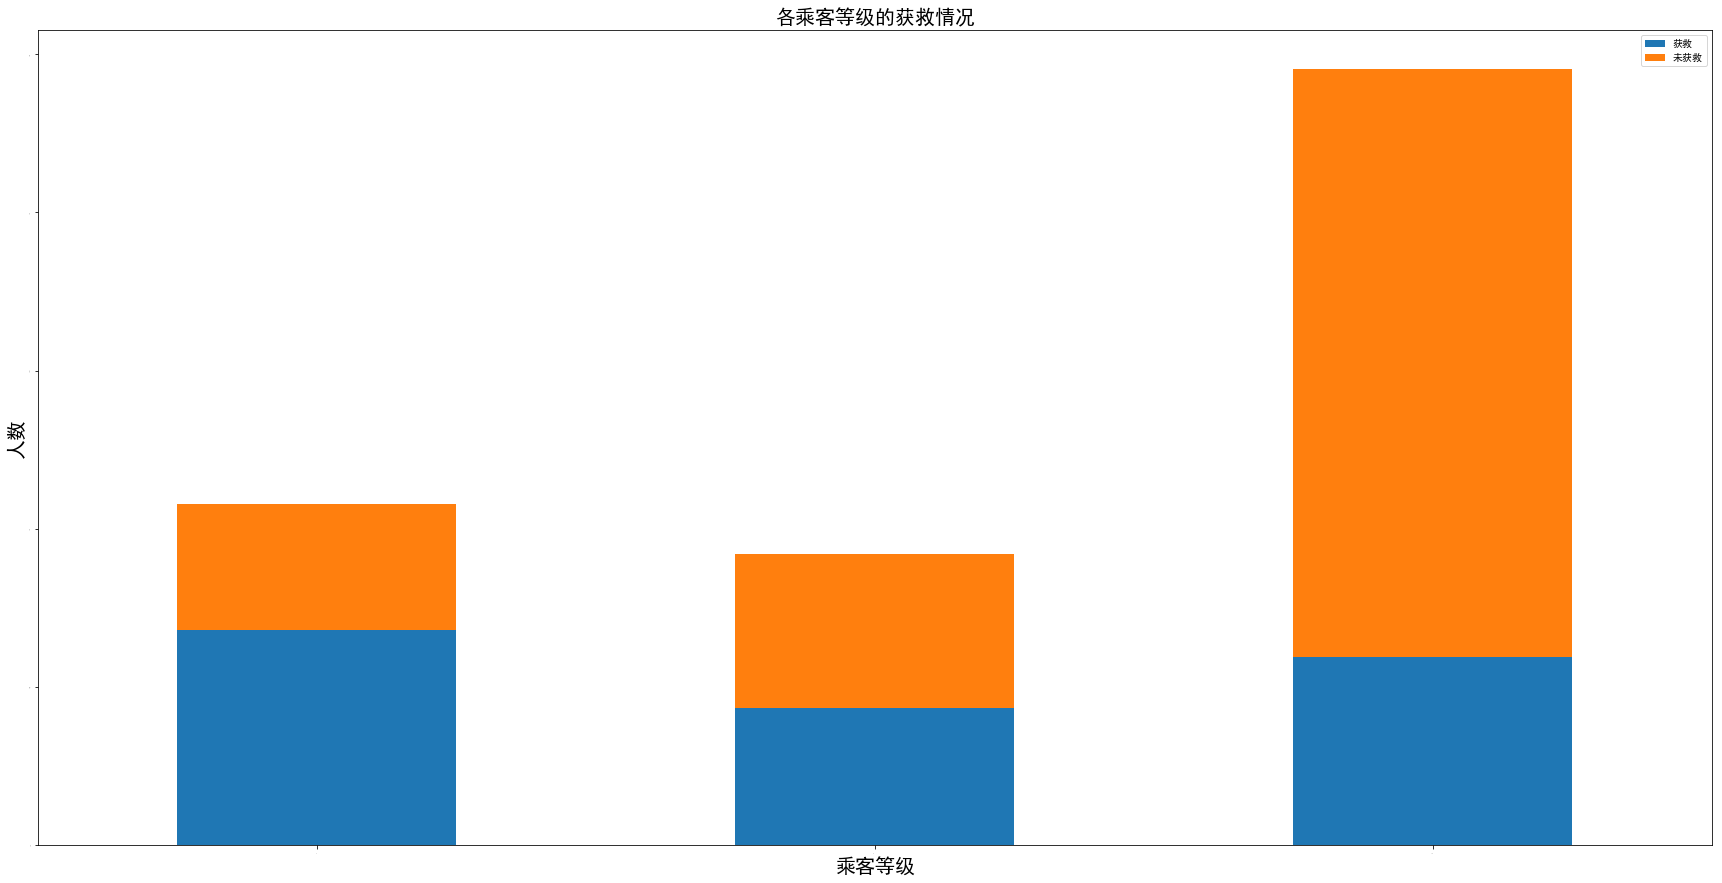

In [26]:
fig=plt.figure()
fig.set(alpha=0.5)

sv_0=train[train['Survived']==0]['Pclass'].value_counts()
sv_1=train[train['Survived']==1]['Pclass'].value_counts()
df=pd.DataFrame({'获救':sv_1,'未获救':sv_0})
df.plot(kind='bar',stacked=True)
plt.title('各乘客等级的获救情况',fontsize=fontsize)
plt.xlabel('乘客等级',fontsize=fontsize)
plt.ylabel('人数',fontsize=fontsize)
plt.show()

0    549
1    342
Name: Survived, dtype: int64

In [22]:
train['Embarked'].mode()[0]

'S'

In [23]:
#这里采用的方法是对连续值用该列的平均值进行填充，非连续值用该列的众数进行填充，
def handle_na(train,test):
    #cabin去除
    #FARE用均值填充
    fare_mean=train['Fare'].mean()
    test.loc[pd.isnull(test['Fare']),'Fare']=fare_mean
    
    #embarked 用众数填充
    embarked_mode=train['Embarked'].mode()
    train.loc[pd.isnull(train['Embarked']),'Embarked']=embarked_mode[0]
    
    #用均值填充Age
    train.loc[pd.isnull(train['Age']),'Age']=train['Age'].mean()
    test.loc[pd.isnull(train['Age']),'Age']=train['Age'].mean()
    return train,test

new_train,new_test=handle_na(train,test)

In [24]:
#由于Embarked，Sex，Pclass特征是离散特征，所以对其进行one-hot/get_dummies编码
new_train=pd.get_dummies(new_train,columns=['Embarked','Sex','Pclass'])
new_test=pd.get_dummies(new_test,columns=['Embarked','Sex','Pclass'])

In [25]:
new_train

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.000000,1,0,A/5 21171,7.2500,NaN,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,1,0,PC 17599,71.2833,C85,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,1,0,113803,53.1000,C123,0,0,1,1,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35.000000,0,0,373450,8.0500,NaN,0,0,1,0,1,0,0,1
5,6,0,"Moran, Mr. James",29.699118,0,0,330877,8.4583,NaN,0,1,0,0,1,0,0,1
6,7,0,"McCarthy, Mr. Timothy J",54.000000,0,0,17463,51.8625,E46,0,0,1,0,1,1,0,0
7,8,0,"Palsson, Master. Gosta Leonard",2.000000,3,1,349909,21.0750,NaN,0,0,1,0,1,0,0,1
8,9,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.000000,0,2,347742,11.1333,NaN,0,0,1,1,0,0,0,1
9,10,1,"Nasser, Mrs. Nicholas (Adele Achem)",14.000000,1,0,237736,30.0708,NaN,1,0,0,1,0,0,1,0


In [36]:
#然后再去除掉PassengerId，Name，Ticket，Cabin, Survived列，这里不使用这些特征做预测
target=train['Survived'].values
df_train=new_train.drop(['PassengerId','Name','Ticket','Cabin','Survived'],axis=1).values
df_test=new_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1).values
df_test_1=new_test.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [33]:
df_train

array([[22.        ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [38.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [26.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [29.69911765,  1.        ,  2.        , ...,  0.        ,
         0.        ,  1.        ],
       [26.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [32.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [37]:
df_test_1.head()

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,0,0,1,0,0,1
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


## Xgboost

In [38]:
#booster [default=gbtree]：可选项为gbtree，gblinear或dart；其中gbtree和dart是使用基于树模型的，而gblinear是使用基于线性模型的；
#silent [default=0]：0表示输出运行信息，1表示不输出；
#nthread [如果不进行设置，默认是最大线程数量]：表示XGBoost运行时的并行线程数量；
#disable_default_eval_metric [default=0]：标记以禁用默认度量标准。设置 >0 表示禁用；
#num_pbuffer [通过XGBoost自动设置，不需要用户来设置]：预测缓冲区的大小，通常设置为训练实例的数量；
#num_feature [通过XGBoost自动设置，不需要用户来设置]：被使用在boosting中的特征维度，设置为最大化的特征维度；


In [48]:
#使用XGBoost原声版本模型
X_train,X_test,y_train,y_test=train_test_split(df_train,target,test_size=0.3,random_state=1)

data_train=xgb.DMatrix(X_train,y_train)## 使用XGBoost的原生版本需要对数据进行转化
data_test=xgb.DMatrix(X_test,y_test)

param={'max_depth':5,'eta':1,'objective':'binary:logistic'}
watchlist=[(data_test,'test'),(data_train,'train')]
n_round=3
booster=xgb.train(param,data_train,num_boost_round=n_round,evals=watchlist)
#计算错误率
y_predicted=booster.predict(data_test)
y=data_test.get_label()

accuracy=sum(y==(y_predicted>0.5))
accuracy_rate=float(accuracy)/len(y_predicted)
print('样本数:{}'.format(len(y_predicted)))
print('正确数目：{}'.format(accuracy))
print('正确率：{:.3f}'.format(accuracy_rate))

[14:28:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[0]	test-error:0.231343	train-error:0.126806
[14:28:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[1]	test-error:0.227612	train-error:0.117175
[14:28:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[2]	test-error:0.223881	train-error:0.104334
样本数:268
正确数目：208
正确率：0.776


In [50]:
#XGBoost的sklearn的接口版本用法与sklearn中的模型的用法相同，这里简单的进行使用
#X_train,X_test,y_train,y_test = train_test_split(df_train,target,test_size = 0.3,random_state = 1)
 
#model = xgb.XGBClassifier(max_depth=3, n_estimators=200, learn_rate=0.01)
#model.fit(X_train, y_train)  
#test_score = model.score(X_test, y_test)
#print('test_score: {0}'.format(test_score))


#参数
'''
class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

max_depth : int  表示基学习器的最大深度；
learning_rate : float  表示学习率，相当于原生版本的 "eta";
n_estimators: int  表示去拟合的boosted  tree数量；
silent：boolean  表示是否在运行boosting期间打印信息；
objective：string or callable  指定学习任务和相应的学习目标或者一个自定义的函数被使用，具体看原生版本的objective；
booster：string  指定要使用的booster，可选项为：gbtree，gblinear 或 dart；
n_jobs：int  在运行XGBoost时并行的线程数量。
gamma：float  在树的叶节​步分区所需的最小损失的减少值，即加入新节点进入的复杂度的代价；
min_child_weight ： int  在子节点中实例权重的最小的和；
max_delta_step ： int  我们允许的每棵树的权重估计最大的delta步骤；
subsample ：float  训练样本的子采样率；
colsample_bytree ：float  构造每个树时列的子采样率。
colsample_bylevel ：float  在每一层中的每次切分节点时的列采样率；
reg_alpha ：float  相当于原生版本的alpha，表示L1正则化项的权重系数；
reg_lambda： float  相当于原生版本的lambda，表示L2正则化项的权重系数；
scale_pos_weight：float  用来平衡正负权重；
base_score：  所有实例的初始预测分数，全局偏差；
random_state：int  随机种子；
missing：float，optional  需要作为缺失值存在的数据中的值。 如果为None，则默认为np.nan。
'''

'\nclass xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective=\'binary:logistic\', booster=\'gbtree\', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)\n\nmax_depth : int  表示基学习器的最大深度；\nlearning_rate : float  表示学习率，相当于原生版本的 "eta";\nn_estimators: int  表示去拟合的boosted  tree数量；\nsilent：boolean  表示是否在运行boosting期间打印信息；\nobjective：string or callable  指定学习任务和相应的学习目标或者一个自定义的函数被使用，具体看原生版本的objective；\nbooster：string  指定要使用的booster，可选项为：gbtree，gblinear 或 dart；\nn_jobs：int  在运行XGBoost时并行的线程数量。\ngamma：float  在树的叶节\u200b步分区所需的最小损失的减少值，即加入新节点进入的复杂度的代价；\nmin_child_weight ： int  在子节点中实例权重的最小的和；\nmax_delta_step ： int  我们允许的每棵树的权重估计最大的delta步骤；\nsubsample ：float  训练样本的子采样率；\ncolsample_bytree ：float  构造每个树时列的子采样率。\ncolsample_bylevel ：float  在每一层中的每次切分节点时的列采样率；\nreg_alpha ：float  相

## 使用其他模型与XGBoost对比

In [66]:
model_lr=LogisticRegression()
model_rf=RandomForestClassifier(n_estimators=200)
model_xgb=xgb.XGBClassifier(max_depth=5, n_estimators=200, learn_rate=0.01)
models=[model_lr,model_rf,model_xgb]
model_name=['LogisticRegression', '随机森林', 'XGBoost']
cv=ShuffleSplit(n_splits=3,test_size=0.3, random_state=1)
for i in range(3):
    print(model_name[i] + ":")
    model = models[i]
    for train, test in cv.split(df_train,target):    
        model.fit(df_train[train], target[train])
        train_score = model.score(df_train[train], target[train])
        test_score = model.score(df_train[test], target[test])
        print('train score: {:.5f} \t test score: {:.5f}'.format(train_score, test_score))


LogisticRegression:
train score: 0.81380 	 test score: 0.77612
train score: 0.81862 	 test score: 0.74254
train score: 0.82022 	 test score: 0.77239
随机森林:
train score: 0.98876 	 test score: 0.76866
train score: 0.99037 	 test score: 0.77985
train score: 0.99037 	 test score: 0.75746
XGBoost:
train score: 0.95185 	 test score: 0.74627
train score: 0.96629 	 test score: 0.79478
train score: 0.95345 	 test score: 0.78358


In [62]:
train.shape

(623,)

In [63]:
test.shape

(268,)

In [64]:
model.score(df_train[train], target[train])

0.9534510433386838

In [65]:
model.score(df_train[test], target[test])

0.7835820895522388